# Read in the simulation data
The first thing to do is read the ouput file. The original tutorial is set up to save a file called `da smd tcl.out`. It is a file with three columns of data that is space delimited. I think pandas can do this pretty simply.

In [6]:
# import the typical modules
import pandas as pd
import numpy as np
from numpy import array, arange, pi, exp, sin, cos, polyfit, poly1d, linspace, zeros, flipud
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import fmin
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

In [3]:
#Read the file into a pandas dataframe
alanine_df = pd.read_csv('./da_smd_tcl.out', header=None, delimiter=' ')
# may need to replace delimiter=' ' with delim_whitespace=True

#Give the columns names
alanine_df.columns = ['timestep_ps', 'distance_A', 'force']
alanine_df

,timestep_ps,distance_A,force
0,0.0,13.406936,-2.929936
1,0.1,13.238905,-1.720047
2,0.2,13.144921,-1.043285
3,0.3,13.352918,-2.540792
4,0.4,13.389590,-2.804762
5,0.5,13.203074,-1.461773
6,0.6,13.109335,-0.786783
7,0.7,13.003528,-0.024900
8,0.8,12.904282,0.689746
9,0.9,12.751601,1.789124


### Create some variables and an expected (constrained) position array

In [4]:
v = 0.0000001 #velocity (A/ps). We used 0.0000002 A/timestep and a timestep is 2 fs
dt = 100 #the data that was saved every 50 steps with 2 fs timesteps gives 100 ps intervals
z_0 = 13
z_N = 33

#create a numpy array of the expected position vs. time (constrained position, c)
c = np.arange(z_0, z_N, v*dt)

### Plot the data and the constrained position to make sure the protein is following the pulling.

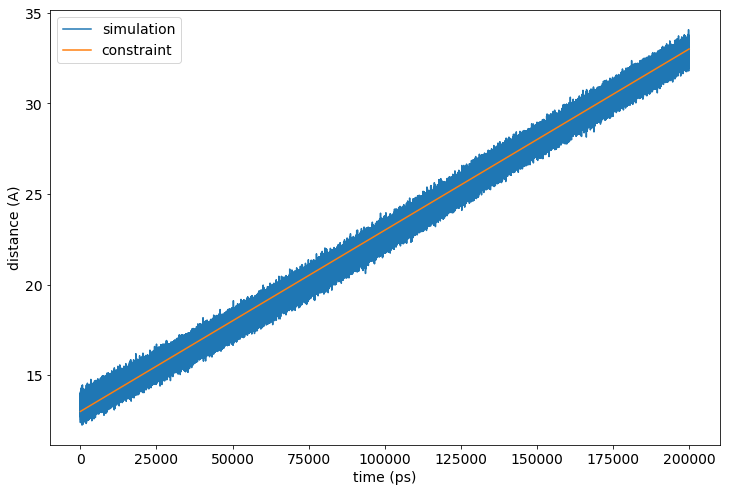

In [7]:
#Let's plot the constrained position and the simulation position to see if it is constant velocity
plt.plot(alanine_df['timestep_ps'], alanine_df['distance_A'], label='simulation')
plt.plot(alanine_df['timestep_ps'],c, label='constraint')
plt.xlabel('time (ps)')
plt.ylabel('distance (A)')
plt.legend(loc=2)
plt.show()

### Force vs. Distance
We can also plot the force as a function of distance, which should be the work if we integrate it.

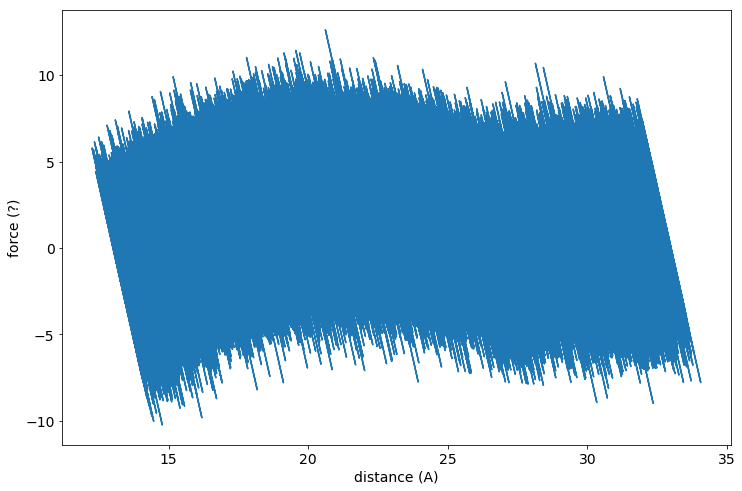

In [8]:
#Let's plot the force vs. distance
plt.plot(alanine_df['distance_A'], alanine_df['force'])
plt.xlabel('distance (A)')
plt.ylabel('force (?)')
plt.show()

# Calcwork1.tcl
This script analyzes a single trajectory (no Jarzynski's equality). We need to convert this tcl script to Python. The contents of the script are below.

```tcl
set w {}
set fsum 0
foreach ftemp $f {
  set fsum [expr $fsum + $ftemp * $v * $dt]
  lappend w $fsum
}```

This script is using predefined variables and arrays. It uses the definition of `v` and `dt`. It uses the array of forces that were in the da_smd_tcl.out file, which in the tutorial are given the name f. We named them alanine_df['force'].
The process of the script is
1. create an array called `w`
2. create a variable to store the sum of force `fsum=0`.
3. loop through the force array and calculate the net work done as total_force*dx
4. append the new work array element to the work array

Let's translate that to Python.

In [9]:
rows, cols = alanine_df.shape
w = np.zeros(rows)
index = 0
fsum = 0
for ftemp in alanine_df['force']:
    fsum += ftemp*v*dt
    w[index] = fsum
    index += 1

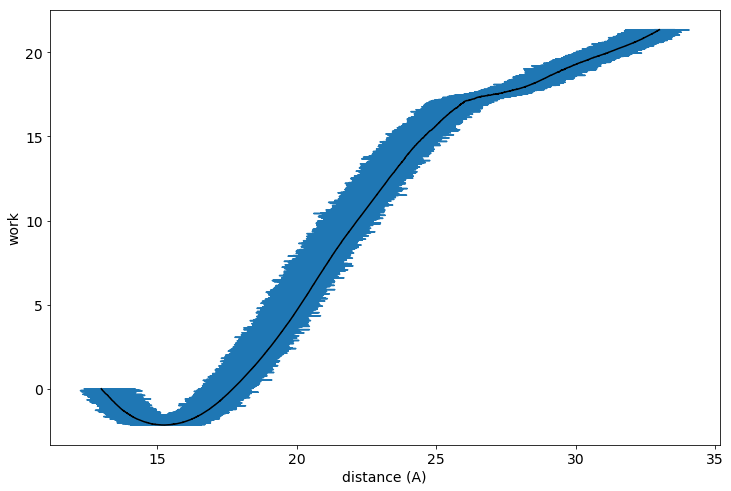

In [10]:
#Let's plot the constrained position and the simulation position to see if it is constant velocity
plt.plot(alanine_df['distance_A'], w)
plt.plot(c, w, 'k')
plt.xlabel('distance (A)')
plt.ylabel('work')
plt.show()

### What about multiple trajectories? Calcwork2.tcl
To use Jarzynski's Equality, we need multiple trials or trajectories, i.e., we need to rerun the pulling many times. The analysis for the work for multiple trajectories just means looping over the number of trajectories. The calcwork2.tcl script does this as a loop over ```l``` and making the work array 2D ```w[m][l]```, where ```m``` is the number of timesteps and ```l``` is the number of trajectories. Here is the contents of calcwork2.tcl

```tcl
foreach l [array names f] {
   set w($l) {}
   set fsum 0
   foreach ftemp $f($l) {
       set fsum [expr $fsum + $ftemp * $v * $dt]
       lappend w($l) $fsum
   }
}```

### Cumulants
Once we have a 2D array of work for all of our trajectories, we need to run the cumulants.tcl script. This one is a bit more complicated, but it is still surprisingly simple. The contents of the script are

```tcl
set Fexp {}
set F1 {}
set F2 {}

for {set i 0} {$i < 20001} {incr i 1} {
   set texp 0
   set t1 0
   set t2 0

   foreach l [array names w] {
   
     set e [lindex $w($l) $i] 
     set texp [expr $texp + exp([expr - $e / $T]) ]
     set t1 [expr $t1 + $e]
     set t2 [expr $t2 + $e * $e]
   }
   lappend Fexp [expr - $T * log([expr $texp / 10])]
   lappend F1 [expr $t1 / 10]
   lappend F2 [expr $t1 / 10  - $t2 / 10  + $t1 * $t1 / 100 ]
}```

### Running the tutorial example
The tutorial includes a 10 trajectory example. It is run with different velocity and timestep values than above.

In [11]:
#Read the file into a pandas dataframe
ten_df = pd.read_csv('./da.dat', header=None, delimiter='    ',engine='python')
# may need to replace delimiter=' ' with delim_whitespace=True
#Give the columns names
ten_df.columns = ['t', 'd01', 'd02', 'd03', 'd04', 'd05', 'd06', 'd07', 'd08', 'd09', 'd10', 'f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10']
ten_df

,t,d01,d02,d03,d04,d05,d06,d07,d08,d09,...,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10
0,0.0,13.202000,13.666000,12.935000,13.270000,13.160000,13.275000,13.770000,13.282000,12.923000,...,-1.454398,-4.795203,0.467997,-1.944003,-1.151999,-1.979997,-5.544003,-2.030397,0.554398,-2.534402
1,0.1,13.234738,13.825296,13.126671,13.117573,13.330689,13.293333,13.463926,13.208879,13.327068,...,-1.682913,-5.934932,-0.904830,-0.839328,-2.373762,-2.104799,-3.333069,-1.496731,-2.347691,-1.965275
2,0.2,12.999116,13.796723,12.965595,13.074573,13.627076,13.407264,13.218116,13.013102,13.368724,...,0.020768,-5.722008,0.262114,-0.522524,-4.500549,-2.917900,-1.556034,-0.079935,-2.640416,0.727232
3,0.3,12.862520,13.474333,12.686948,13.389563,13.284248,13.339374,13.288420,13.200516,13.642713,...,1.011459,-3.393600,2.275577,-2.783253,-2.024985,-2.421893,-2.055021,-1.422112,-4.605937,0.741469
4,0.4,13.115700,13.564798,12.841442,13.432780,13.067946,13.432234,13.034476,13.509253,13.078235,...,-0.804238,-4.037745,1.170420,-3.087216,-0.460411,-3.083283,-0.219424,-3.637823,-0.534492,-1.970179
5,0.5,13.357109,13.362677,12.685931,13.095854,13.210898,13.384878,13.265840,13.052115,13.501340,...,-2.535182,-2.575273,2.297295,-0.654150,-1.482465,-2.735118,-1.878051,-0.339230,-3.573647,-3.269416
6,0.6,13.234004,13.323283,12.735386,13.172378,13.117534,13.325076,13.240805,12.674723,13.477325,...,-1.641628,-2.284441,1.948419,-1.197921,-0.803042,-2.297349,-1.690594,2.385191,-3.393543,-3.823303
7,0.7,12.836279,13.452736,12.918617,13.540185,13.376931,13.521020,13.253072,13.004652,13.520228,...,1.229191,-3.209301,0.636360,-3.838932,-2.663506,-3.700941,-1.771720,0.016909,-3.695240,-5.220264
8,0.8,12.851597,13.228824,13.033541,13.465267,13.337343,13.531218,12.953870,13.277736,13.588142,...,1.126105,-1.589931,-0.183897,-3.292322,-2.371268,-3.767167,0.389739,-1.942096,-4.177025,-2.991248
9,0.9,13.110691,13.234262,12.750729,13.079647,13.367270,13.172090,12.786571,13.185562,13.233905,...,-0.732175,-1.621889,1.859549,-0.508657,-2.579545,-1.174248,1.601489,-1.271249,-1.619317,-4.420041


### Ten trajectory file format
Ok, the format is time (ps), d1, d2, d3, ... d10, f1, f2, ... f10. That is, a row is a particular timestep with the distances for each trajectory then the forces for each trajectory. Let's try and plot all 10 trajectories. But first let's load the Fexact data.

In [12]:
#Read the file into a pandas dataframe
exact_df = pd.read_csv('./Fexact.dat', header=None, delim_whitespace=True)
# may need to replace delimiter=' ' with delim_whitespace=True
#Give the columns names
exact_df.columns = ['distance_A', 'force']
exact_df

,distance_A,force
0,13.0,-0.0000
1,13.1,-0.1749
2,13.2,-0.3613
3,13.3,-0.5234
4,13.4,-0.6882
5,13.5,-0.8530
6,13.6,-1.0076
7,13.7,-1.1344
8,13.8,-1.2703
9,13.9,-1.3916


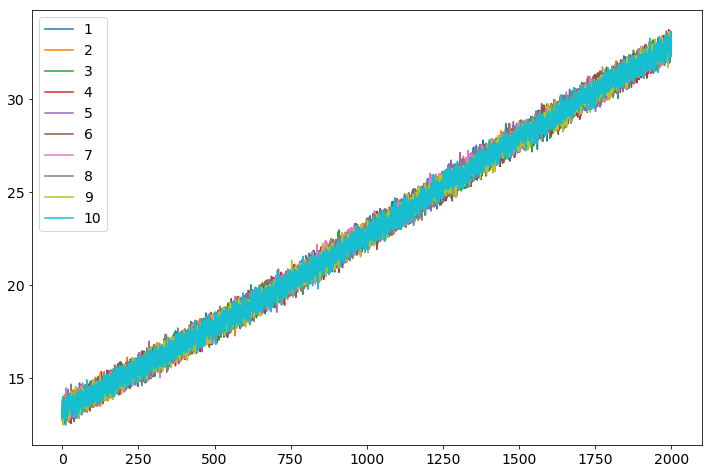

In [13]:
plt.plot(ten_df['t'], ten_df['d01'], label='1')
plt.plot(ten_df['t'], ten_df['d02'], label='2')
plt.plot(ten_df['t'], ten_df['d03'], label='3')
plt.plot(ten_df['t'], ten_df['d04'], label='4')
plt.plot(ten_df['t'], ten_df['d05'], label='5')
plt.plot(ten_df['t'], ten_df['d06'], label='6')
plt.plot(ten_df['t'], ten_df['d07'], label='7')
plt.plot(ten_df['t'], ten_df['d08'], label='8')
plt.plot(ten_df['t'], ten_df['d09'], label='9')
plt.plot(ten_df['t'], ten_df['d10'], label='10')
plt.legend(loc='upper left')
plt.show()

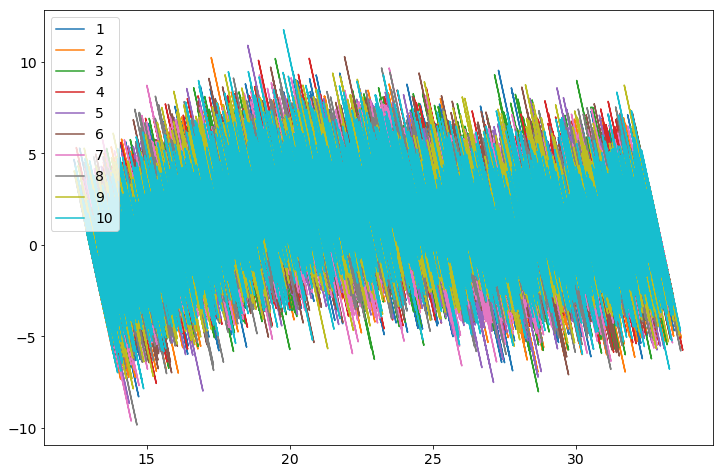

In [14]:
plt.plot(ten_df['d01'], ten_df['f01'], label='1')
plt.plot(ten_df['d02'], ten_df['f02'], label='2')
plt.plot(ten_df['d03'], ten_df['f03'], label='3')
plt.plot(ten_df['d04'], ten_df['f04'], label='4')
plt.plot(ten_df['d05'], ten_df['f05'], label='5')
plt.plot(ten_df['d06'], ten_df['f06'], label='6')
plt.plot(ten_df['d07'], ten_df['f07'], label='7')
plt.plot(ten_df['d08'], ten_df['f08'], label='8')
plt.plot(ten_df['d09'], ten_df['f09'], label='9')
plt.plot(ten_df['d10'], ten_df['f10'], label='10')
plt.legend(loc='upper left')
plt.show()

### Create separate dataframes
I'm going to split the large dataframe into time, distance and force dataframes. I think this will make looping through to do calculations a little easier to think about.

In [15]:
#iterate over dataframe rows
#for index, row in df.iterrows() :
#    print(row['A'], row['B'])
#split the dataframe into times, distances, forces dataframes
times_tut = ten_df['t']
distances_tut = ten_df.iloc[:, 1:11]
forces_tut = ten_df.iloc[:, 11:21]


### The calculations
Ok, it's time to do the equivalent of calcwork2.tcl. This data has different ```dt``` and ```v``` values. When we get to the cumulants.tcl analysis, we'll need to have the thermal energy $k_BT$. The units used are kcal/mol.

$$\left(1.381\times10^{-23} J/K\right)\left(6.02\times10^{23} particles/mol\right)\left(300 K\right) = 2494 J/mol$$

Converting to kcal

$$2492 J/mol \times 1 kcal/4184 J = 0.596 kcal/mol$$

The pandas dataframes make looping unnecessary. We can run a cumulative sum on the columns (add the elements in each row to the sum of the elements from preceding rows). Then we can multiply by $v dt$.

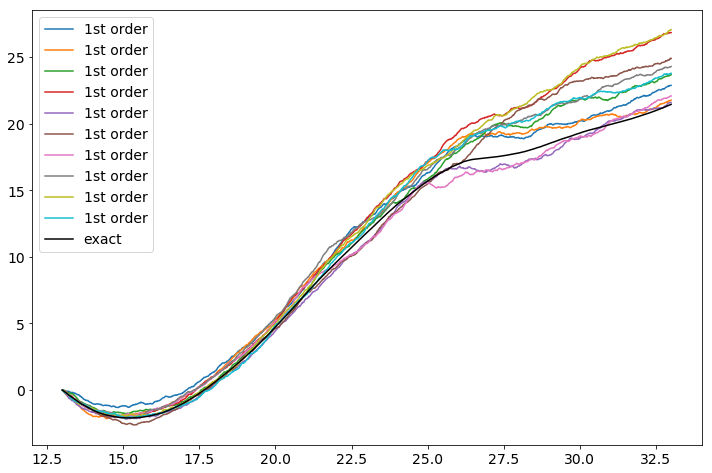

In [16]:
dt_tutorial = 0.1
v_tutorial = 0.01
kBT = 0.6 #kcal/mol so really RT
#create a numpy array of the expected position vs. time (constrained position, c)
c_tutorial = np.arange(z_0, z_N+0.001, v_tutorial*dt_tutorial)

w_tut = (forces_tut*v_tutorial*dt_tutorial).cumsum(axis=0) #cumulative sum of forces (integrating)

plt.plot(c_tutorial, w_tut, label='1st order')
#plt.plot(c_tutorial, w_tut['f02'], label='2')
#plt.plot(c_tutorial, w_tut['f03'], label='3')
#plt.plot(c_tutorial, w_tut['f04'], label='4')
#plt.plot(c_tutorial, w_tut['f05'], label='5')
#plt.plot(c_tutorial, w_tut['f06'], label='6')
#plt.plot(c_tutorial, w_tut['f07'], label='7')
#plt.plot(c_tutorial, w_tut['f08'], label='8')
#plt.plot(c_tutorial, w_tut['f09'], label='9')
#plt.plot(c_tutorial, w_tut['f10'], label='10')
plt.plot(exact_df['distance_A'],exact_df['force'], 'k', label='exact' )
plt.legend(loc='upper left')
plt.show()

### Implement cumulants.tcl
Ok, it's time to apply the Jarzynski Equality. The first order cumulant is just an average of the ten trajectories' work. That one is simplest. Let's do it first.

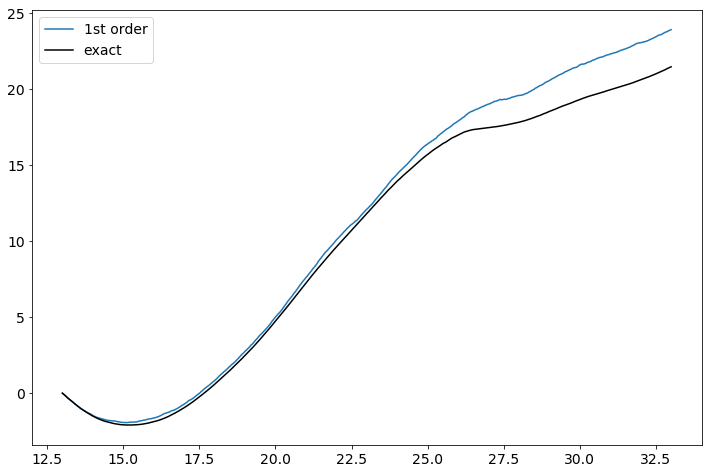

In [17]:
f1_tut = w_tut.sum(axis=1) #add across trajectories
f1_tut /= 10 #divide by number of trajectories to get average

plt.plot(c_tutorial, f1_tut, label='1st order')
plt.plot(exact_df['distance_A'],exact_df['force'], 'k', label='exact' )
plt.legend(loc='upper left')
plt.show()

### The second order cumulant

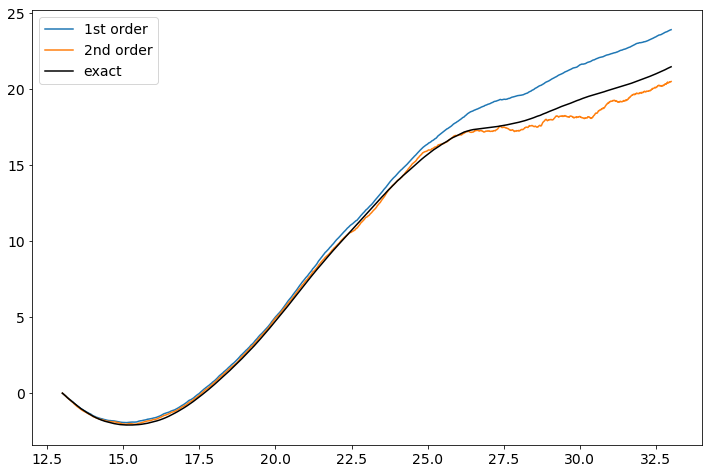

In [18]:
f2_tut = (w_tut**2).sum(axis=1) #add across the trajectories
f2_tut /= 10 #average 10 trajectories

f2_tut = f1_tut - f2_tut + f1_tut**2

plt.plot(c_tutorial, f1_tut, label='1st order')
plt.plot(c_tutorial, f2_tut, label='2nd order')
plt.plot(exact_df['distance_A'],exact_df['force'], 'k', label='exact' )
plt.legend(loc='upper left')
plt.show()

### The exponential average

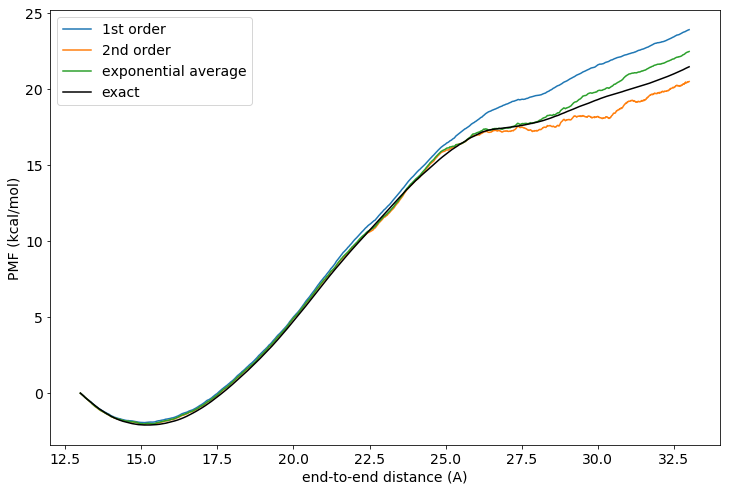

In [22]:
fexp_tut = (np.exp(-w_tut/kBT)).sum(axis=1) #add across the trajectories
fexp_tut = -kBT * np.log(fexp_tut/10) #average 10 trajectories


plt.plot(c_tutorial, f1_tut, label='1st order')
plt.plot(c_tutorial, f2_tut, label='2nd order')
plt.plot(c_tutorial, fexp_tut, label='exponential average')
plt.plot(exact_df['distance_A'],exact_df['force'], 'k', label='exact' )
plt.legend(loc='upper left')
plt.xlabel('end-to-end distance (A)')
plt.ylabel('PMF (kcal/mol)')
plt.show()